In [25]:
#Transferencia de Aprendizaje / Transfer Learning
# conda activate tf-gpu

In [26]:
#Crear nuestro propio conjunto de datos

In [27]:
# !unzip bichofue/bichofue.zip -d bichofue

In [28]:
# !unzip oso/oso.zip -d oso

In [29]:
# !rm -rf bichofue/bichofue.zip
# !rm -rf oso/oso.zip

In [30]:
#Crear un set de datos (ya no en memoria)

# !mkdir dataset
# !cp -r bichofue dataset/bichofue
# !cp -r oso dataset/oso

In [31]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices("GPU"))


TensorFlow version: 2.20.0
GPU disponible: []


In [32]:
# REINICIAR DESDE AQUÍ SI YA SE CARGARON LAS IMÁGENES
#Aumento de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.15,
    height_shift_range = 0.15,
    shear_range = 5,
    zoom_range = [0.7, 1.3],
    validation_split = 0.2
)

data_gen_entrenamiento = datagen.flow_from_directory("dataset",
                                                     target_size=(224,224),
                                                     batch_size=32, shuffle=True,
                                                     subset="training")

data_gen_pruebas = datagen.flow_from_directory("dataset",
                                                     target_size=(224,224),
                                                     batch_size=32, shuffle=True,
                                                     subset="validation")

Found 610 images belonging to 2 classes.
Found 151 images belonging to 2 classes.


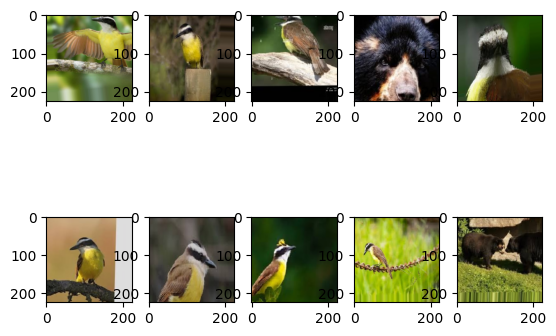

In [33]:
import matplotlib.pyplot as plt

for imagenes, etiquetas in data_gen_entrenamiento:
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(imagenes[i])
        # plt.axis("off")
    break

plt.show()


In [34]:
import tensorflow as tf
import tensorflow_hub as hub

url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
## mobilenetv2 = hub.KerasLayer(url, input_shape=(224, 224, 3))

In [35]:
# # MODIFICADO
# # Capa base (preentrenada)
# base_model = hub.KerasLayer(
#     url,
#     input_shape=(224, 224, 3),
#     trainable=False  # congelamos pesos
# )

# # Functional API (CORREGIDO)
# inputs = tf.keras.Input(shape=(224, 224, 3))
# x = tf.keras.layers.Lambda(lambda t: base_model(t, training=False))(inputs)
# outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

# modelo = tf.keras.Model(inputs, outputs)

In [36]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling="avg"   # 👈 equivale a feature_vector
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

modelo = tf.keras.Model(inputs, outputs)


In [37]:
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [38]:
#Importante
#Congelar las capas
## mobilenetv2.trainable = False

In [39]:
## modelo = tf.keras.Sequential([
##     mobilenetv2,
##     tf.keras.layers.Dense(2, activation="softmax")
## ])

In [40]:
EPOCAS = 20
entrenamiento = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)
modelo.save("modelo_clasificador_bichofue_oso_anteojos.keras")

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 975ms/step - accuracy: 0.6852 - loss: 0.5961 - val_accuracy: 0.8146 - val_loss: 0.4521
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 607ms/step - accuracy: 0.8393 - loss: 0.4148 - val_accuracy: 0.9536 - val_loss: 0.3161
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 605ms/step - accuracy: 0.9213 - loss: 0.2766 - val_accuracy: 0.9801 - val_loss: 0.2308
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 619ms/step - accuracy: 0.9590 - loss: 0.2114 - val_accuracy: 0.9669 - val_loss: 0.1832
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 663ms/step - accuracy: 0.9770 - loss: 0.1614 - val_accuracy: 0.9868 - val_loss: 0.1255
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 607ms/step - accuracy: 0.9689 - loss: 0.1385 - val_accuracy: 0.9801 - val_loss: 0.1082
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 605ms/step - accuracy: 0.9787 - loss: 0.1117 - val_accuracy: 0.9934 - val_loss: 0.0885
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 602ms/step - accuracy: 0.9787 - loss: 0.1069 - val_accu

In [41]:
## from PIL import Image
## import cv2

## def categorizar(ruta):
##   img = Image.open(ruta)
##   img = img.convert("RGB")
##   img = np.array(img).astype(float)/255

##   img = cv2.resize(img, (224, 224))
##   prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
##   return np.argmax(prediccion[0], axis=-1)

In [42]:
# import numpy as np
# from PIL import Image

# def categorizar(ruta):
#     img = Image.open(ruta).convert("RGB")
#     img = img.resize((224, 224))   # 👈 reemplaza cv2.resize
#     img = np.array(img).astype("float32") / 255.0

#     img = np.expand_dims(img, axis=0)  # (1, 224, 224, 3)
#     prediccion = modelo.predict(img, verbose=0)

#     return np.argmax(prediccion[0])


In [43]:
print(data_gen_entrenamiento.class_indices)

{'bichofue': 0, 'oso': 1}


In [44]:
import numpy as np
from PIL import Image

CLASES = ["bichofue", "oso"]

def categorizar(ruta):
    img = Image.open(ruta).convert("RGB")
    img = img.resize((224, 224))
    img = np.array(img).astype("float32") / 255.0

    img = np.expand_dims(img, axis=0)  # (1, 224, 224, 3)
    pred = modelo.predict(img, verbose=0)[0]

    indice = np.argmax(pred)
    etiqueta = CLASES[indice]
    confianza = pred[indice]

    return etiqueta, float(confianza)

In [45]:
# ruta = "oso.jpg"
# prediccion = categorizar(ruta)
# print(prediccion)

In [46]:
# ruta = "bichofue.jpg"
# prediccion = categorizar(ruta)
# print(prediccion)

Predicción: oso
Confianza: 98.92%


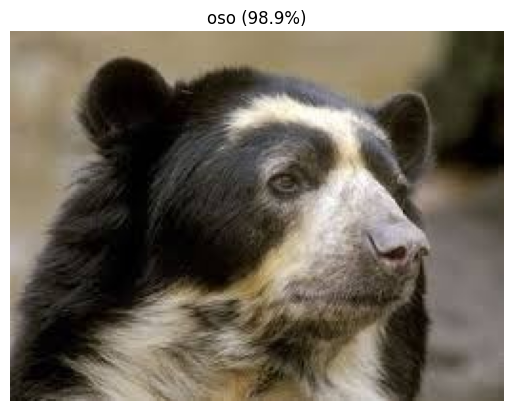

In [47]:
import matplotlib.pyplot as plt

ruta = "oso.jpg"
img = Image.open(ruta)

etiqueta, confianza = categorizar(ruta)

print(f"Predicción: {etiqueta}")
print(f"Confianza: {confianza:.2%}")

plt.imshow(img)
plt.axis("off")
plt.title(f"{etiqueta} ({confianza:.1%})")
plt.show()


Predicción: bichofue
Confianza: 90.54%


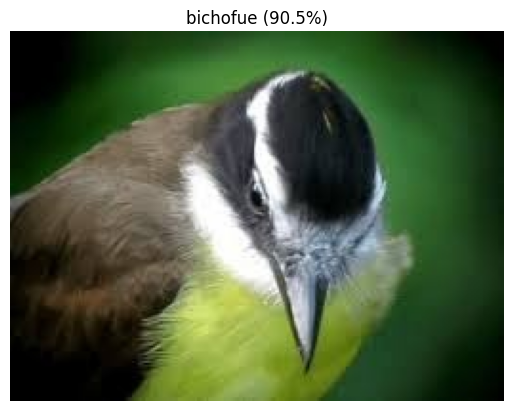

In [48]:
ruta = "bichofue.jpg"
img = Image.open(ruta)

etiqueta, confianza = categorizar(ruta)

print(f"Predicción: {etiqueta}")
print(f"Confianza: {confianza:.2%}")

plt.imshow(img)
plt.axis("off")
plt.title(f"{etiqueta} ({confianza:.1%})")
plt.show()